# Example extracted from Chapter 19 in:
<img src=guttag.jpg>

En este ejemplo vamos a aplicar k-means a un conjunto de objetos pertenecientes a una clase ejemplo. El procedimiento de clustering se lleva cabo en base a la clase Cluster, en concreto mediante el método que figura al final de este notebook. 

Como siempre, el primer estadio corresponde a la importación de los paquetes necesarios para realizar el ejemplo. 

In [1]:
import random, string, copy
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

**En este ejemplo vamos a utilizar la distancia de Minkowski, que está definida tal y como sigue:**


$$
    d(x_i,x_j) = (|x_{i,1} -x_{j,1}|)^p + |x_{i,2} -x_{j,2}|)^p +\cdots + |x_{i,N} -x_{j,N}|^p)^{1/p}         
$$    
       


In [2]:
def minkowskiDist(v1, v2, p):
    """Asume que v1 y v2 son de igual longitud y que son vectores numéricos
       Devuelve la distancia de Minkowski de orden p entre v1 y v2"""
    dist = 0.0
    for i in range(len(v1)):
        dist += abs(v1[i] - v2[i])**p
    return dist**(1.0/p)


**Los ejemplos se realizarán empleando la clase auxiliar Example**:

- En primer lugar, hemos de definir el constructor de la clase (def \_init\_).
- Tras ello, escribimos cada uno de los métodos atributo de la clase.
- Finalmente, tendremos un método para imprimir la clase Example.


In [3]:
class Example(object):
    
    def __init__(self, name, features, label = None):
        #Asume que las caracterísiticas es un vector numérico
        self.name = name
        self.features = features
        self.label = label
        
    def dimensionality(self):
        return len(self.features)
    
    def getFeatures(self):
        return self.features[:]
    
    def getLabel(self):
        return self.label
    
    def getName(self):
        return self.name
    
    def distance(self, other):
        return minkowskiDist(self.features, other.getFeatures(), 2)
    
    def __str__(self):
        return self.name +':'+ str(self.features) + ':' + str(self.label)


**A continuación creamos la clase Cluster.**

In [4]:
class Cluster(object):
    
    def __init__(self, examples, exampleType):
        """Asumimos que examples es una lista de ejemplos de tipo exampleType"""
        self.examples = examples
        self.exampleType = exampleType
        self.centroid = self.computeCentroid()
        
    def update(self, examples):
        """Sustituimos los ejemplos en el cluster por nuevos ejemplos
        Se devuelve una medida sobre elcambio del centroide"""
        oldCentroid = self.centroid
        self.examples = examples
        if len(examples) > 0:
            self.centroid = self.computeCentroid()
            return oldCentroid.distance(self.centroid)
        else:
            return 0.0
        
    def members(self):
        for e in self.examples:
            yield e
        
    def size(self):
        return len(self.examples)
    
    def getCentroid(self):
        return self.centroid
    
    def computeCentroid(self):
        dim = self.examples[0].dimensionality()
        totVals = np.array([0.0]*dim)
        for e in self.examples:
            totVals += e.getFeatures()
        centroid = self.exampleType('centroid',
                              totVals/float(len(self.examples)))
        return centroid
    
    def variance(self):
        totDist = 0.0
        for e in self.examples:
            totDist += (e.distance(self.centroid))**2
        return totDist**0.5
    
    def __str__(self):
        names = []
        for e in self.examples:
            names.append(e.getName())
        names.sort()
        result = 'Cluster con centroide '\
                 + str(self.centroid.getFeatures()) + ' contiene:\n  '
        for e in names:
            result = result + e + ', '
        return result[:-2]


In [5]:
def kmeans(examples, exampleType, k, verbose):
    """Asume que examples es una lista de ejemplos de tipo exampleType. k es un entero positiv y verbose es 
    un booleano que indica si se quiere obtener información de depuración al ejecutar código.    
       La función devuelve una lista que contiene k clusters. Si verbose es True se imprime el resultado de
       cada iteración"""
    #Elegimos k centroides de modo aleatorio
    initialCentroids = random.sample(examples, k)
    
    #Creamos un singleton por cada centroide 
    clusters = []
    for e in initialCentroids:
        clusters.append(Cluster([e], exampleType))
        
    #Se itera hasta que no cambian los centroides
    converged = False
    numIterations = 0
    while not converged:
        numIterations += 1
        #Crea una lista conteniendo k listas distintas vacías
        newClusters = []
        for i in range(k):
            newClusters.append([])

        #Asocia cada ejemplo con el centroid más cercano
        for e in examples:
            #Encuentra el centroide más cercano a e
            smallestDistance = e.distance(clusters[0].getCentroid())
            index = 0
            for i in range(1, k):
                distance = e.distance(clusters[i].getCentroid())
                if distance < smallestDistance:
                    smallestDistance = distance
                    index = i
            #Añade e a la lista de ejemplos asociada al centroide correspondiente
            newClusters[index].append(e)
            
        #Se actualiza cada cluster; se comprueba si ha cambiado el centroide
        converged = True
        for i in range(len(clusters)):
            if clusters[i].update(newClusters[i]) > 0.0:
                converged = False
        if verbose:
            print("Iteration #" + str(numIterations))
            for c in clusters:
                print(c)
            print('') #añade una línea en blanco
    return clusters


In [6]:
def dissimilarity(clusters):
    """Se calcula la cohesion intracluster mediante una suma de la varianza de todos los elementos
    en el cluster con respecto al centroide"""
    totDist = 0.0
    for c in clusters:
        totDist += c.variance()
    return totDist
    
def trykmeans(examples, exampleType, numClusters, numTrials,
              verbose = False):
    """Llama a kmeans numTrials veces y devuelve el resultado con la menor disimilaridad"""
    best = kmeans(examples, exampleType, numClusters, verbose)
    minDissimilarity = dissimilarity(best)
    for trial in range(1, numTrials):
        clusters = kmeans(examples, exampleType, numClusters, verbose)
        currDissimilarity = dissimilarity(clusters)
        if currDissimilarity < minDissimilarity:
            best = clusters
            minDissimilarity = currDissimilarity
    return best


In [10]:
def genDistribution(xMean, xSD, yMean, ySD, n, namePrefix):
    samples = []
    for s in range(n):
        x = random.gauss(xMean, xSD)
        y = random.gauss(yMean, ySD)
        samples.append(Example(namePrefix+str(s), [x, y]))
    return samples

def plotSamples(samples, marker):
    xVals, yVals = [], []
    for s in samples:
        x = s.getFeatures()[0]
        y = s.getFeatures()[1]
        plt.annotate(s.getName(), xy = (x, y),
                       xytext = (x+0.13, y-0.07),
                       fontsize = 'x-large')
        xVals.append(x)
        yVals.append(y)
    plt.plot(xVals, yVals, marker)

def contrivedTest(numTrials, k, verbose):
    random.seed(0)
    xMean = 3
    xSD = 1
    yMean = 5
    ySD = 1
    n = 10
    d1Samples = genDistribution(xMean, xSD, yMean, ySD, n, '1.')
    plotSamples(d1Samples, 'b^')
    d2Samples = genDistribution(xMean+3, xSD, yMean+1, ySD, n, '2.')
    plotSamples(d2Samples, 'ro')
    clusters = trykmeans(d1Samples + d2Samples, Example, k,
                         numTrials, verbose)
    print('Final result')
    for c in clusters:
        print c
    print ''


Iteration #1
Cluster con centroide [ 4.57800047  5.35921276] contiene:
  1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9
Cluster con centroide [ 3.79646584  2.99635148] contiene:
  1.9

Iteration #2
Cluster con centroide [ 4.80105783  5.73986393] contiene:
  1.1, 1.2, 1.4, 1.5, 1.6, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9
Cluster con centroide [ 3.75252146  3.74468698] contiene:
  1.0, 1.3, 1.7, 1.8, 1.9

Iteration #3
Cluster con centroide [ 5.6388835   6.02296994] contiene:
  1.6, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9
Cluster con centroide [ 3.19452848  4.28541384] contiene:
  1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.7, 1.8, 1.9

Iteration #4
Cluster con centroide [ 5.93613865  5.96069975] contiene:
  2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9
Cluster con centroide [ 3.14170883  4.52143963] contiene:
  1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9

Iteration #5
Cluster con centroide [ 5.93613865  5.96069975] contiene:
 

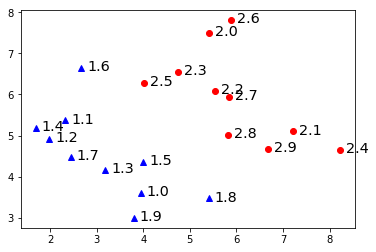

In [12]:
contrivedTest(1,2,True)